Nama: Adhi Viari Nugraha

username: adhi237

Email: viariadhi@gmail.com

In [ ]:
import pandas as pd
df = pd.read_csv('ADANIPORTS.csv')
df.head

<bound method NDFrame.head of             Date      Symbol Series  ...    Trades  Deliverable Volume  %Deliverble
0     2007-11-27  MUNDRAPORT     EQ  ...       NaN             9859619       0.3612
1     2007-11-28  MUNDRAPORT     EQ  ...       NaN             1453278       0.3172
2     2007-11-29  MUNDRAPORT     EQ  ...       NaN             1069678       0.2088
3     2007-11-30  MUNDRAPORT     EQ  ...       NaN             1260913       0.2735
4     2007-12-03  MUNDRAPORT     EQ  ...       NaN              816123       0.2741
...          ...         ...    ...  ...       ...                 ...          ...
3317  2021-04-26  ADANIPORTS     EQ  ...  116457.0              838079       0.0892
3318  2021-04-27  ADANIPORTS     EQ  ...  236896.0             1779639       0.0865
3319  2021-04-28  ADANIPORTS     EQ  ...  130847.0             1342353       0.1203
3320  2021-04-29  ADANIPORTS     EQ  ...  153293.0             1304895       0.0942
3321  2021-04-30  ADANIPORTS     EQ  ...  1321

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3322 non-null   object 
 1   Symbol              3322 non-null   object 
 2   Series              3322 non-null   object 
 3   Prev Close          3322 non-null   float64
 4   Open                3322 non-null   float64
 5   High                3322 non-null   float64
 6   Low                 3322 non-null   float64
 7   Last                3322 non-null   float64
 8   Close               3322 non-null   float64
 9   VWAP                3322 non-null   float64
 10  Volume              3322 non-null   int64  
 11  Turnover            3322 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  3322 non-null   int64  
 14  %Deliverble         3322 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 389.4

In [ ]:
df.shape

(3322, 15)

In [ ]:
df.isnull().sum()

Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Trades                866
Deliverable Volume      0
%Deliverble             0
dtype: int64

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].head()
df = df[['Date','Close']]
df.head()

,Date,Close
0,2007-11-27,962.90
1,2007-11-28,893.90
2,2007-11-29,884.20
3,2007-11-30,921.55
4,2007-12-03,969.30


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3322 non-null   datetime64[ns]
 1   Close   3322 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 52.0 KB


In [ ]:
adanis = df[['Date','Close']].copy()
adanis['just_date'] = adanis['Date'].dt.date

adanisfinal=adanis.drop('Date',axis=1)
adanisfinal.set_index('just_date', inplace= True)
adanisfinal.head()

,Close
just_date,
2007-11-27,962.90
2007-11-28,893.90
2007-11-29,884.20
2007-11-30,921.55
2007-12-03,969.30


In [ ]:
adanisfinal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3322 entries, 2007-11-27 to 2021-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3322 non-null   float64
dtypes: float64(1)
memory usage: 51.9+ KB


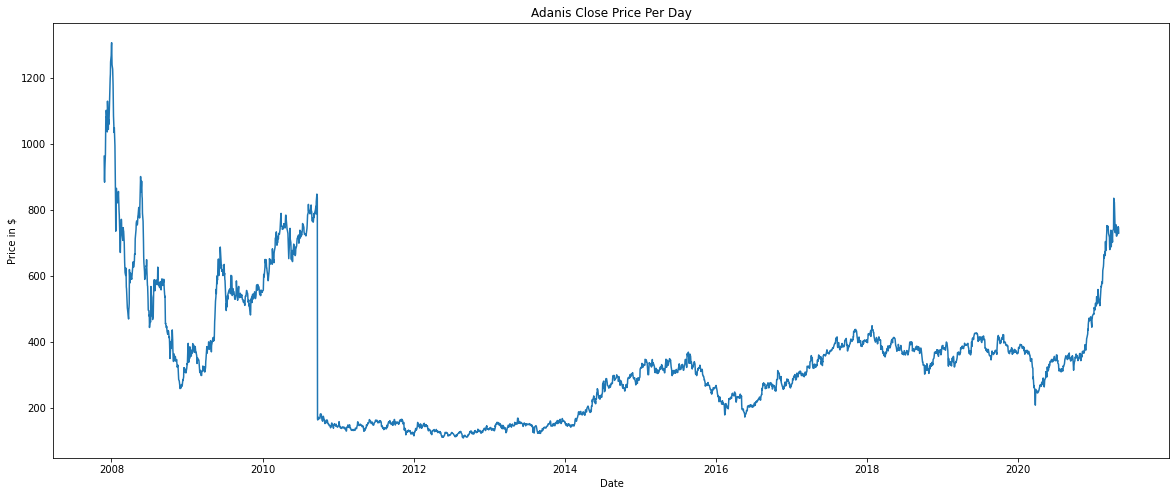

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(adanisfinal)
plt.title('Adanis Close Price Per Day')
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.show()

In [ ]:
#getting the data values
date = df['Date'].values
close = df['Close'].values

In [ ]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(close, date, test_size=0.2, random_state = 0, shuffle=False) #20% validation set

In [ ]:
print(len(x_train), len(x_test))

2657 665


In [ ]:
#model
from keras.layers import Dense, LSTM

data_x_train = windowed_dataset(x_train, window_size=600, batch_size=100, shuffle_buffer=1800)
data_x_test = windowed_dataset(x_test, window_size=600, batch_size=100, shuffle_buffer=1800)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal",activation="relu", input_shape=[None,1]),
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400)
])

learning_rate_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
max = df['Close'].max()
print('Max value : ')
print(max)

Max value : 
1307.45


In [ ]:
min = df['Close'].min()
print('Min Value : ')
print(min)

Min Value : 
108.0


In [ ]:
x = (max - min) * (10/100)
print(x)

119.94500000000001


In [ ]:
#making a callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [ ]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train ,epochs=500, validation_data=data_x_test, callbacks=[callbacks])


Epoch 1/500
21/21 [==============================] - 37s 120ms/step - loss: 356.3314 - mae: 356.8314 - val_loss: 747.8495 - val_mae: 748.3496
Epoch 2/500
21/21 [==============================] - 2s 56ms/step - loss: 320.2596 - mae: 320.7595 - val_loss: 721.3674 - val_mae: 721.8674
Epoch 3/500
21/21 [==============================] - 2s 51ms/step - loss: 289.7232 - mae: 290.2232 - val_loss: 695.8096 - val_mae: 696.3096
Epoch 4/500
21/21 [==============================] - 2s 51ms/step - loss: 246.2369 - mae: 246.7369 - val_loss: 667.1818 - val_mae: 667.6818
Epoch 5/500
21/21 [==============================] - 2s 52ms/step - loss: 220.3714 - mae: 220.8714 - val_loss: 631.3521 - val_mae: 631.8521
Epoch 6/500
21/21 [==============================] - 2s 52ms/step - loss: 206.1013 - mae: 206.6013 - val_loss: 624.9908 - val_mae: 625.4909
Epoch 7/500
21/21 [==============================] - 2s 51ms/step - loss: 199.5886 - mae: 200.0886 - val_loss: 619.0605 - val_mae: 619.5605
Epoch 8/500
21/21 

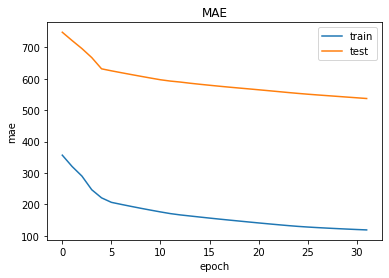

In [ ]:
#plot of MAE
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

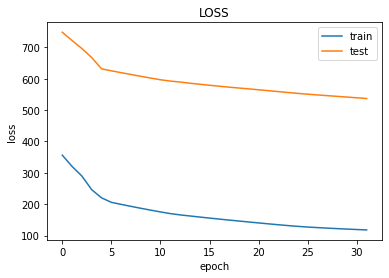

In [ ]:
#plot of loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()